# 🏠 Bengaluru House Price Prediction
## Fully Documented ML Pipeline — Every Step with Visualisations

---

| # | Step | Description |
|---|------|-------------|
| 1 | **Imports & Setup** | Libraries, output dirs |
| 2 | **Load Data** | Read CSV, inspect shape & nulls |
| 3 | **Clean `total_sqft`** | Strip commas, coerce to float |
| 4 | **Feature Engineering** | Create `price_per_sqft` |
| 5 | **Outlier Removal** | Clip 1st–99th percentile |
| 6 | **Rare Location Grouping** | Collapse rare locations → `other` |
| 7 | **EDA** | 6 exploratory plots |
| 8 | **Encoding & Split** | One-hot encode, train/test split |
| 9 | **Feature Scaling** | StandardScaler |
| 10 | **Model Training** | Linear Regression + CV |
| 11 | **Evaluation** | MSE, RMSE, MAE, R², MAPE |
| 12 | **Diagnostics** | 5 model diagnostic plots |
| 13 | **Export `.pkl`** | model, scaler, feature_columns |

> **Dataset:** Bengaluru House Prices — 13,319 listings, 9 columns

## 📦 Step 1 — Imports & Setup
All required libraries loaded here. `matplotlib` is set to inline mode for Colab.

In [3]:
import os, pickle, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

os.makedirs('output_artifacts/plots', exist_ok=True)
print('✅ All libraries imported successfully.')

✅ All libraries imported successfully.


## 📂 Step 2 — Load Dataset

We load the CSV and immediately inspect:
- **Shape** — rows × columns
- **Data types** — catch object columns that should be numeric
- **Null counts** — plan any imputation needed
- **Descriptive statistics** — spot scale/range issues early

A bar chart of missing values makes gaps immediately visible.

In [5]:
df = pd.read_csv('/content/Copy of Cleaned_bengaluru_house_prices - bengaluru_house_prices.csv.csv')

print(f'Shape     : {df.shape[0]:,} rows  ×  {df.shape[1]} columns')
print(f'Columns   : {list(df.columns)}')
df.head()

Shape     : 13,319 rows  ×  9 columns
Columns   : ['area_type', 'availability', 'location', 'size', 'bhk', 'total_sqft', 'bath', 'balcony', 'price']


,area_type,availability,location,size,bhk,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,2,"1,056.00",2,1,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,4,"2,600.00",5,3,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,3,"1,440.00",2,3,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,3,"1,521.00",3,1,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,2,"1,200.00",2,1,51.00


In [6]:
print('\n── dtypes ──')
print(df.dtypes.to_string())
print('\n── Null Counts ──')
print(df.isnull().sum().to_string())


── dtypes ──
area_type        object
availability     object
location         object
size             object
bhk               int64
total_sqft       object
bath              int64
balcony           int64
price           float64

── Null Counts ──
area_type        0
availability     0
location         0
size            16
bhk              0
total_sqft       0
bath             0
balcony          0
price            0


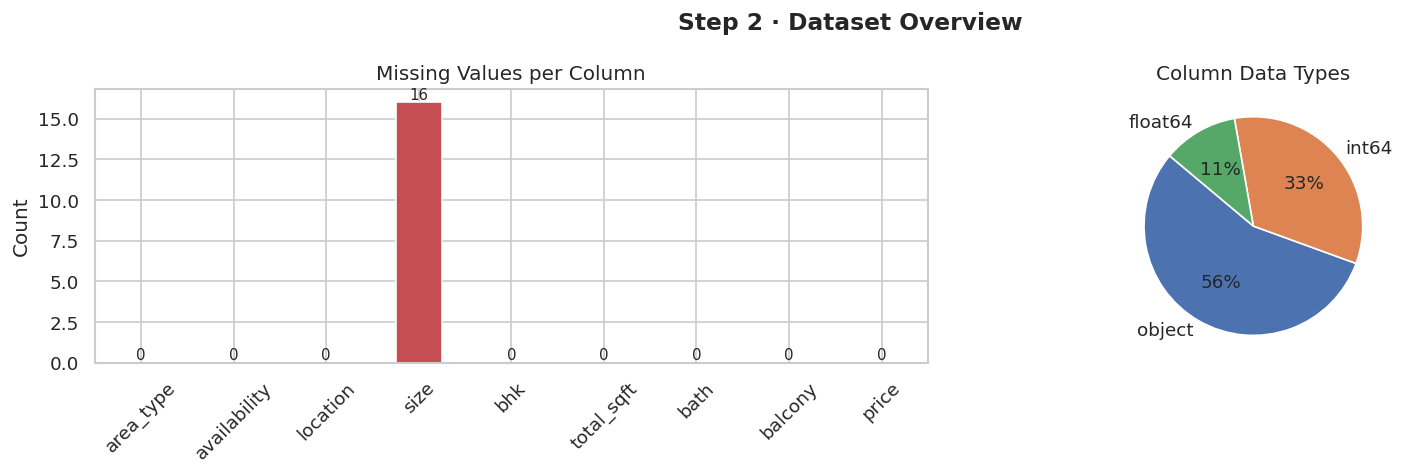

✅ Dataset loaded — shape: (13319, 9)


In [7]:
# ── PLOT: Missing Value Heatmap ──────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Step 2 · Dataset Overview', fontsize=14, fontweight='bold')

# Null bar chart
null_counts = df.isnull().sum()
null_counts.plot(kind='bar', ax=axes[0], color='#C44E52', edgecolor='white')
axes[0].set_title('Missing Values per Column')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(null_counts):
    axes[0].text(i, v + 0.2, str(v), ha='center', fontsize=9)

# Dtype distribution pie
dtype_counts = df.dtypes.astype(str).value_counts()
axes[1].pie(dtype_counts.values, labels=dtype_counts.index,
            autopct='%1.0f%%', startangle=140,
            colors=['#4C72B0','#DD8452','#55A868'])
axes[1].set_title('Column Data Types')

plt.tight_layout()
plt.savefig('output_artifacts/plots/01_dataset_overview.png', bbox_inches='tight')
plt.show()
print('✅ Dataset loaded — shape:', df.shape)

In [ ]:
df.describe()

## 🧹 Step 3 — Clean `total_sqft`

**Problem:** `total_sqft` is stored as a string with comma-thousands separators (e.g. `'1,056.00'`).  
**Fix:** Strip commas → coerce to `float` → drop rows that couldn't be parsed (range strings like `'1200 - 1400'`).

We visualise the distribution **before vs after** to confirm no data is lost improperly.

In [8]:
# Capture raw string values before cleaning for comparison
raw_sqft_sample = df['total_sqft'].astype(str).str.replace(',','').pipe(pd.to_numeric, errors='coerce')

before_rows = len(df)

df['total_sqft'] = (
    df['total_sqft']
    .astype(str)
    .str.replace(',', '', regex=False)
    .pipe(pd.to_numeric, errors='coerce')   # un-parseable → NaN
)

df.dropna(subset=['total_sqft'], inplace=True)
after_rows = len(df)

print(f'Rows before  : {before_rows:,}')
print(f'Rows removed : {before_rows - after_rows}')
print(f'Rows after   : {after_rows:,}')
print(f'total_sqft → min {df["total_sqft"].min():.0f}  |  max {df["total_sqft"].max():.0f}  |  mean {df["total_sqft"].mean():.1f}')

Rows before  : 13,319
Rows removed : 0
Rows after   : 13,319
total_sqft → min 1  |  max 1122000  |  mean 1861.7


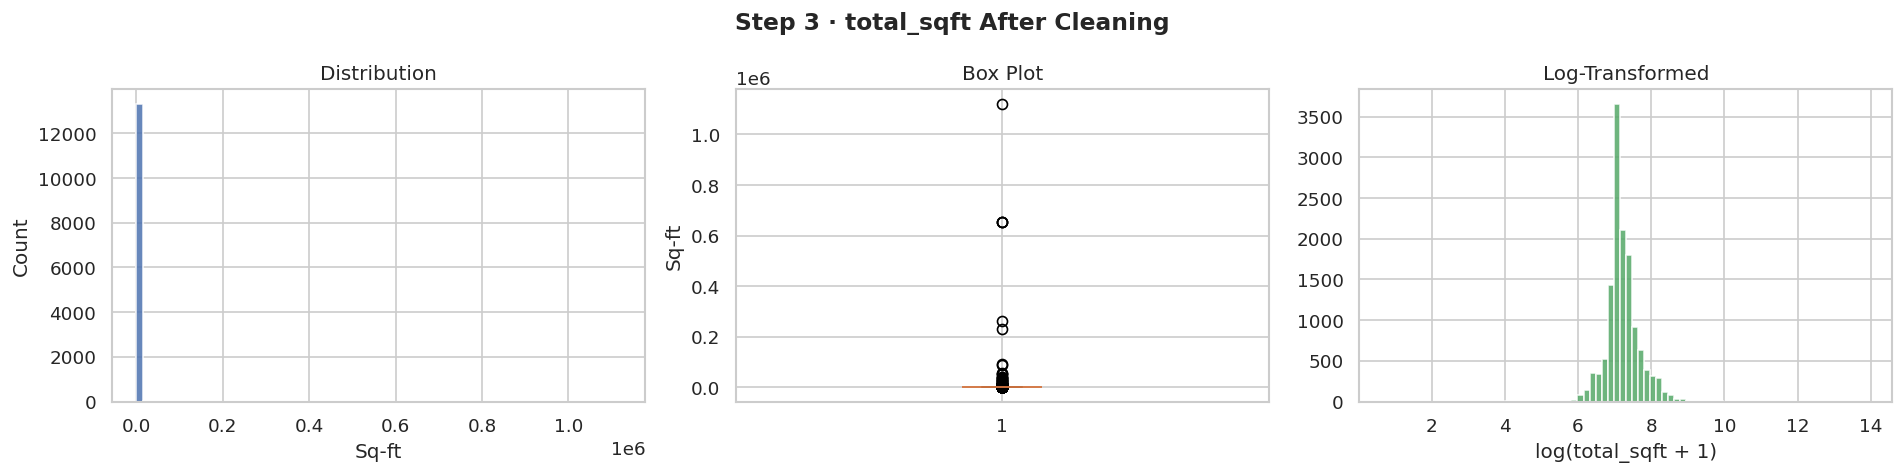

In [9]:
# ── PLOT: total_sqft distribution after cleaning ─────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 3 · total_sqft After Cleaning', fontsize=14, fontweight='bold')

# Histogram
axes[0].hist(df['total_sqft'], bins=80, color='#4C72B0', edgecolor='white', alpha=0.85)
axes[0].set_xlabel('Sq-ft')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution')

# Box plot
axes[1].boxplot(df['total_sqft'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#4C72B0', alpha=0.7))
axes[1].set_title('Box Plot')
axes[1].set_ylabel('Sq-ft')

# Log-scale histogram (handles heavy right skew)
axes[2].hist(np.log1p(df['total_sqft']), bins=80, color='#55A868', edgecolor='white', alpha=0.85)
axes[2].set_xlabel('log(total_sqft + 1)')
axes[2].set_title('Log-Transformed')

plt.tight_layout()
plt.savefig('output_artifacts/plots/02_total_sqft_cleaning.png', bbox_inches='tight')
plt.show()

## ⚙️ Step 4 — Feature Engineering: `price_per_sqft`

**Why?** Raw `price` conflates size and quality. A 5,000 sqft flat at ₹100L is *cheap*; a 500 sqft flat at ₹80L is *expensive*.  
`price_per_sqft = (price × 100,000) / total_sqft` creates a **size-normalised** quality signal used for outlier detection.

> `price` is in **Lakhs INR** (1 Lakh = ₹1,00,000)

In [10]:
df['price_per_sqft'] = (df['price'] * 100_000) / df['total_sqft']

print('price_per_sqft summary:')
print(df['price_per_sqft'].describe().to_frame().T.to_string())

price_per_sqft summary:
                  count         mean            std       min          25%          50%          75%         max
price_per_sqft  13319.0  7902.669662  106253.171841  7.346189  4262.295082  5428.571429  7312.468691  12000000.0


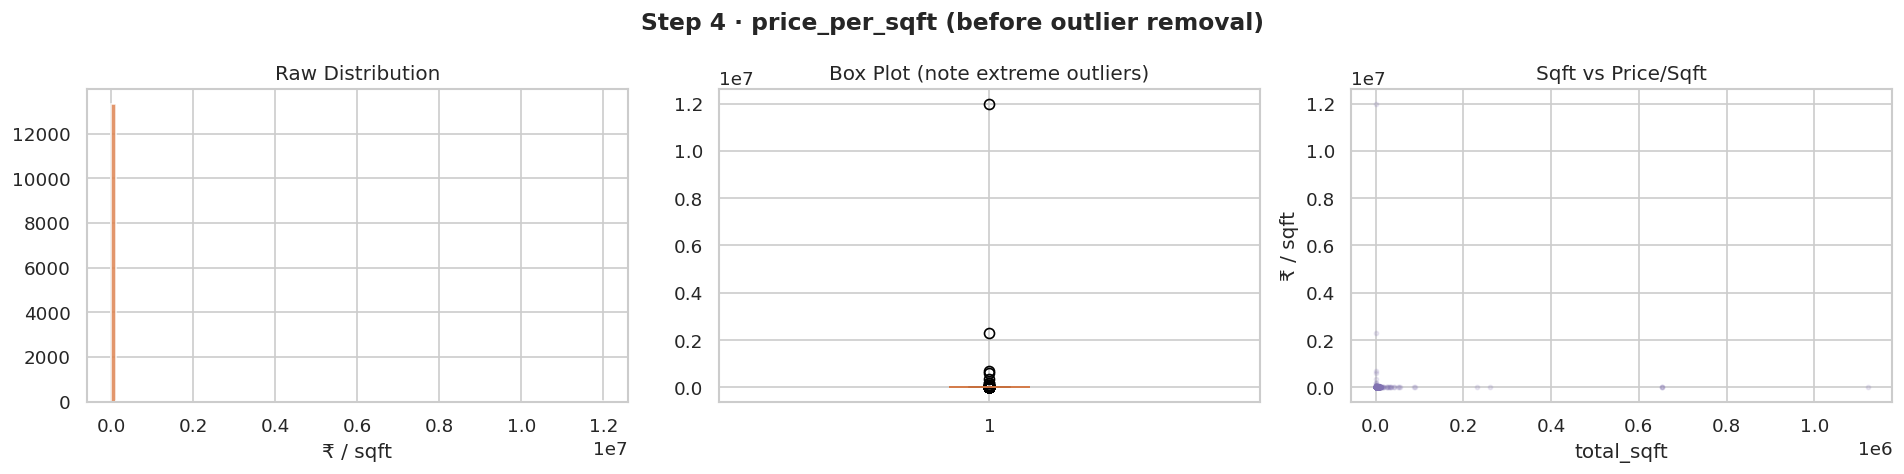

In [11]:
# ── PLOT: price_per_sqft raw distribution ─────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 4 · price_per_sqft (before outlier removal)', fontsize=14, fontweight='bold')

axes[0].hist(df['price_per_sqft'], bins=100, color='#DD8452', edgecolor='white', alpha=0.85)
axes[0].set_xlabel('₹ / sqft')
axes[0].set_title('Raw Distribution')

axes[1].boxplot(df['price_per_sqft'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#DD8452', alpha=0.7))
axes[1].set_title('Box Plot (note extreme outliers)')

axes[2].scatter(df['total_sqft'], df['price_per_sqft'], alpha=0.15, s=6, color='#8172B2')
axes[2].set_xlabel('total_sqft')
axes[2].set_ylabel('₹ / sqft')
axes[2].set_title('Sqft vs Price/Sqft')

plt.tight_layout()
plt.savefig('output_artifacts/plots/03_price_per_sqft_raw.png', bbox_inches='tight')
plt.show()

## ✂️ Step 5 — Outlier Removal (1st–99th Percentile)

We remove the bottom **1%** and top **1%** of `price_per_sqft`.

**Why percentile-based?**  
IQR-based removal (1.5×IQR) can be too aggressive on right-skewed real estate data.  
The 1–99 band keeps 98% of data while eliminating data-entry errors and ultra-luxury anomalies.

The plot below shows the **before/after** density — notice how the right tail is trimmed.

In [12]:
lo     = df['price_per_sqft'].quantile(0.01)
hi     = df['price_per_sqft'].quantile(0.99)
before = len(df)

df_before = df.copy()   # keep for plotting
df = df[(df['price_per_sqft'] >= lo) & (df['price_per_sqft'] <= hi)]

removed = before - len(df)
print(f'Lower bound (1st pct)  : ₹{lo:,.0f} / sqft')
print(f'Upper bound (99th pct) : ₹{hi:,.0f} / sqft')
print(f'Outliers removed       : {removed:,}  ({100*removed/before:.1f}%)')
print(f'Rows remaining         : {len(df):,}')

Lower bound (1st pct)  : ₹2,500 / sqft
Upper bound (99th pct) : ₹23,711 / sqft
Outliers removed       : 251  (1.9%)
Rows remaining         : 13,068


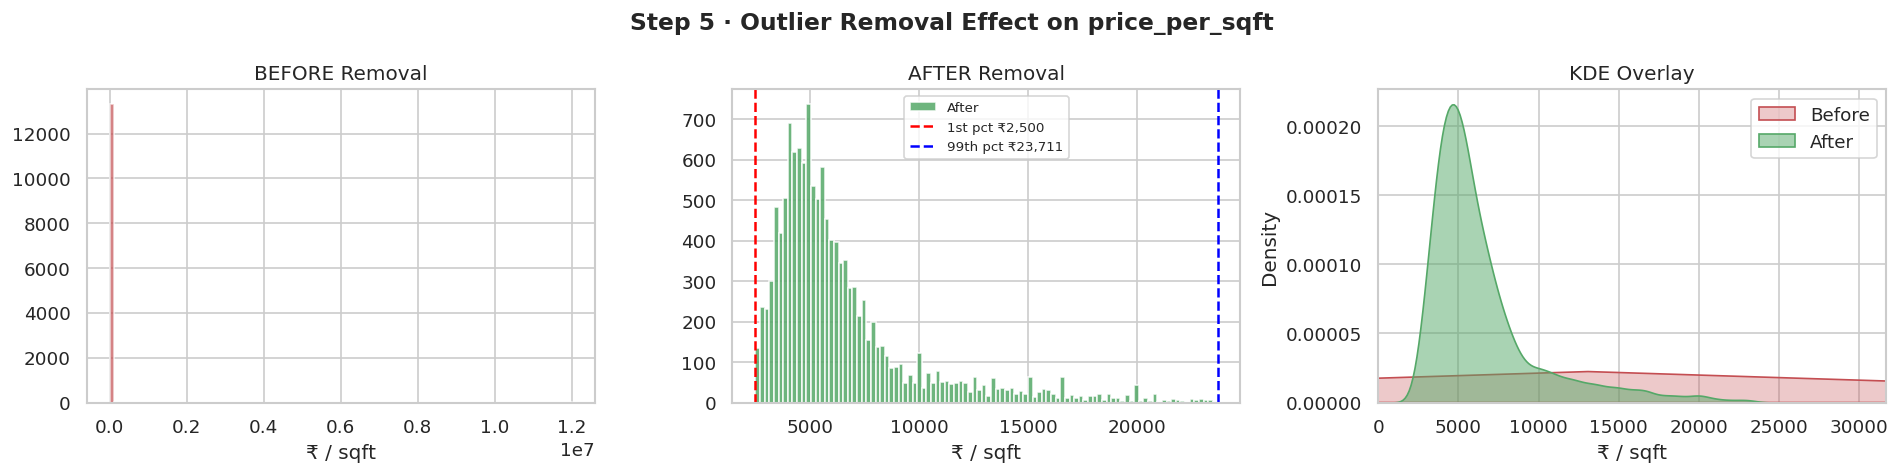

In [13]:
# ── PLOT: Before vs After outlier removal ─────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 5 · Outlier Removal Effect on price_per_sqft', fontsize=14, fontweight='bold')

axes[0].hist(df_before['price_per_sqft'], bins=120, color='#C44E52', edgecolor='white', alpha=0.7, label='Before')
axes[0].set_title('BEFORE Removal')
axes[0].set_xlabel('₹ / sqft')

axes[1].hist(df['price_per_sqft'], bins=100, color='#55A868', edgecolor='white', alpha=0.85, label='After')
axes[1].axvline(lo, color='red',  linestyle='--', linewidth=1.5, label=f'1st pct ₹{lo:,.0f}')
axes[1].axvline(hi, color='blue', linestyle='--', linewidth=1.5, label=f'99th pct ₹{hi:,.0f}')
axes[1].set_title('AFTER Removal')
axes[1].set_xlabel('₹ / sqft')
axes[1].legend(fontsize=8)

# Overlay both as KDE
sns.kdeplot(df_before['price_per_sqft'], ax=axes[2], label='Before', color='#C44E52', fill=True, alpha=0.3)
sns.kdeplot(df['price_per_sqft'],        ax=axes[2], label='After',  color='#55A868', fill=True, alpha=0.5)
axes[2].set_title('KDE Overlay')
axes[2].set_xlabel('₹ / sqft')
axes[2].legend()
axes[2].set_xlim(0, df_before['price_per_sqft'].quantile(0.997))

plt.tight_layout()
plt.savefig('output_artifacts/plots/04_outlier_removal.png', bbox_inches='tight')
plt.show()

## 📍 Step 6 — Rare Location Grouping

There are **1,294 unique locations** in the raw data. Locations with ≤ 10 listings:
- Don't provide enough samples to learn a reliable price coefficient
- Explode the one-hot encoded feature matrix unnecessarily

These are collapsed into a single `'other'` category.

The plot shows the long-tail distribution of location counts.

In [14]:
loc_counts    = df['location'].value_counts()
rare_locs     = loc_counts[loc_counts <= 10].index
df_before_loc = df.copy()

df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locs else x)

print(f'Unique locations before : {len(loc_counts)}')
print(f'Unique locations after  : {df["location"].nunique()}')
print(f'Collapsed into other    : {len(rare_locs)}')

Unique locations before : 1269
Unique locations after  : 237
Collapsed into other    : 1033


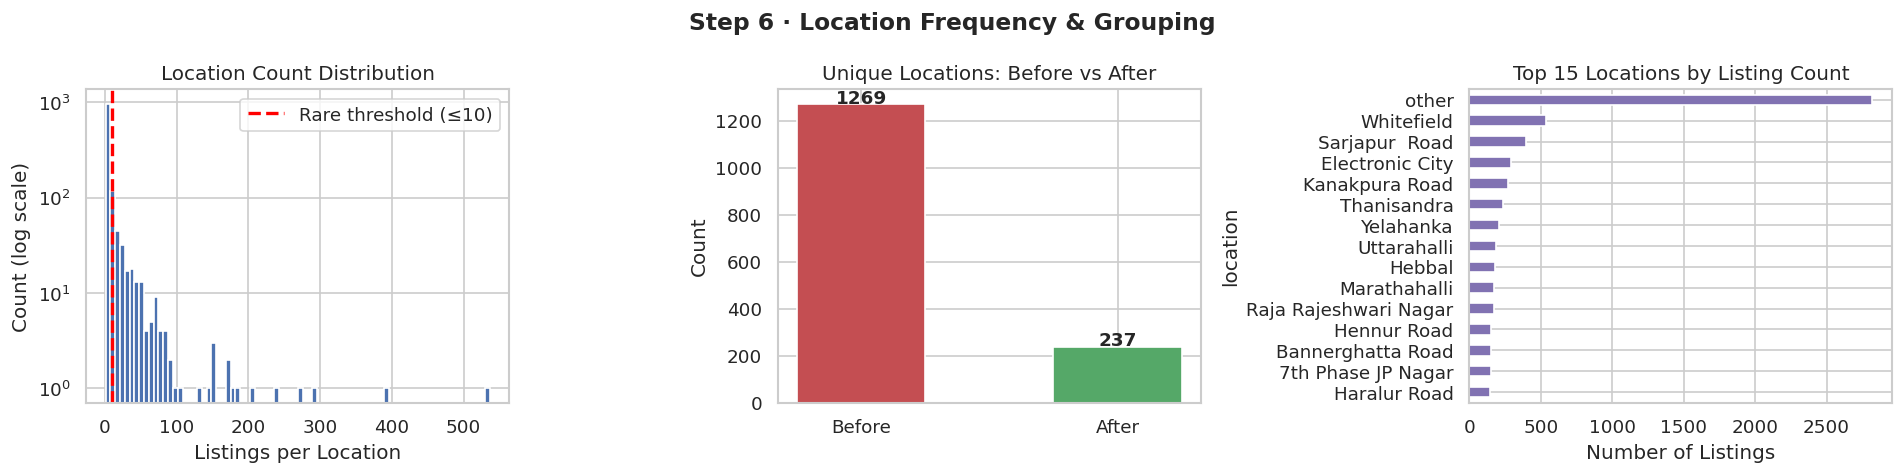

In [15]:
# ── PLOT: Location frequency long-tail ────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 6 · Location Frequency & Grouping', fontsize=14, fontweight='bold')

# Log-scale histogram of location counts (long tail)
axes[0].hist(loc_counts.values, bins=80, color='#4C72B0', edgecolor='white', log=True)
axes[0].axvline(10, color='red', linestyle='--', linewidth=2, label='Rare threshold (≤10)')
axes[0].set_xlabel('Listings per Location')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('Location Count Distribution')
axes[0].legend()

# Before vs After unique locations bar
axes[1].bar(['Before', 'After'], [len(loc_counts), df['location'].nunique()],
            color=['#C44E52','#55A868'], edgecolor='white', width=0.5)
axes[1].set_title('Unique Locations: Before vs After')
axes[1].set_ylabel('Count')
for i, v in enumerate([len(loc_counts), df['location'].nunique()]):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Top 15 locations by listing count
top15 = df['location'].value_counts().head(15)
top15.plot(kind='barh', ax=axes[2], color='#8172B2', edgecolor='white')
axes[2].set_title('Top 15 Locations by Listing Count')
axes[2].set_xlabel('Number of Listings')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('output_artifacts/plots/05_location_grouping.png', bbox_inches='tight')
plt.show()

## 📊 Step 7 — Exploratory Data Analysis (EDA)

Six targeted visualisations to understand the data before modelling.

### 7a · Target Variable — Price Distribution

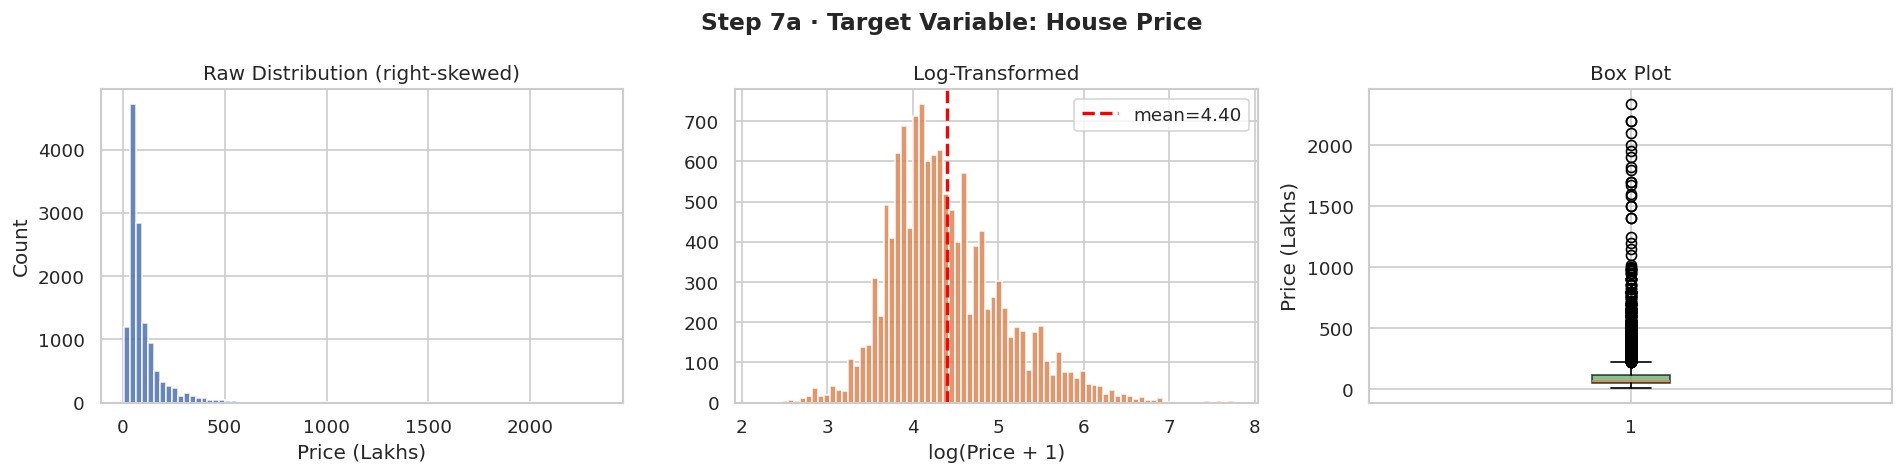

Shapiro-Wilk on log(price): W=0.9656  p=6.0773e-33
→ Departure from normality (expected at large n)


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 7a · Target Variable: House Price', fontsize=14, fontweight='bold')

axes[0].hist(df['price'], bins=80, color='#4C72B0', edgecolor='white', alpha=0.85)
axes[0].set_xlabel('Price (Lakhs)')
axes[0].set_ylabel('Count')
axes[0].set_title('Raw Distribution (right-skewed)')

axes[1].hist(np.log1p(df['price']), bins=80, color='#DD8452', edgecolor='white', alpha=0.85)
axes[1].set_xlabel('log(Price + 1)')
axes[1].set_title('Log-Transformed')
mu = np.mean(np.log1p(df['price']))
axes[1].axvline(mu, color='red', linestyle='--', linewidth=2, label=f'mean={mu:.2f}')
axes[1].legend()

axes[2].boxplot(df['price'], patch_artist=True,
                boxprops=dict(facecolor='#55A868', alpha=0.7))
axes[2].set_title('Box Plot')
axes[2].set_ylabel('Price (Lakhs)')

plt.tight_layout()
plt.savefig('output_artifacts/plots/06_price_distribution.png', bbox_inches='tight')
plt.show()

sample = df['price'].sample(min(5000, len(df)), random_state=42)
stat, p = stats.shapiro(np.log1p(sample))
print(f'Shapiro-Wilk on log(price): W={stat:.4f}  p={p:.4e}')
print('→ log(price) appears approximately normal' if p > 0.05 else '→ Departure from normality (expected at large n)')

### 7b · Correlation Heatmap

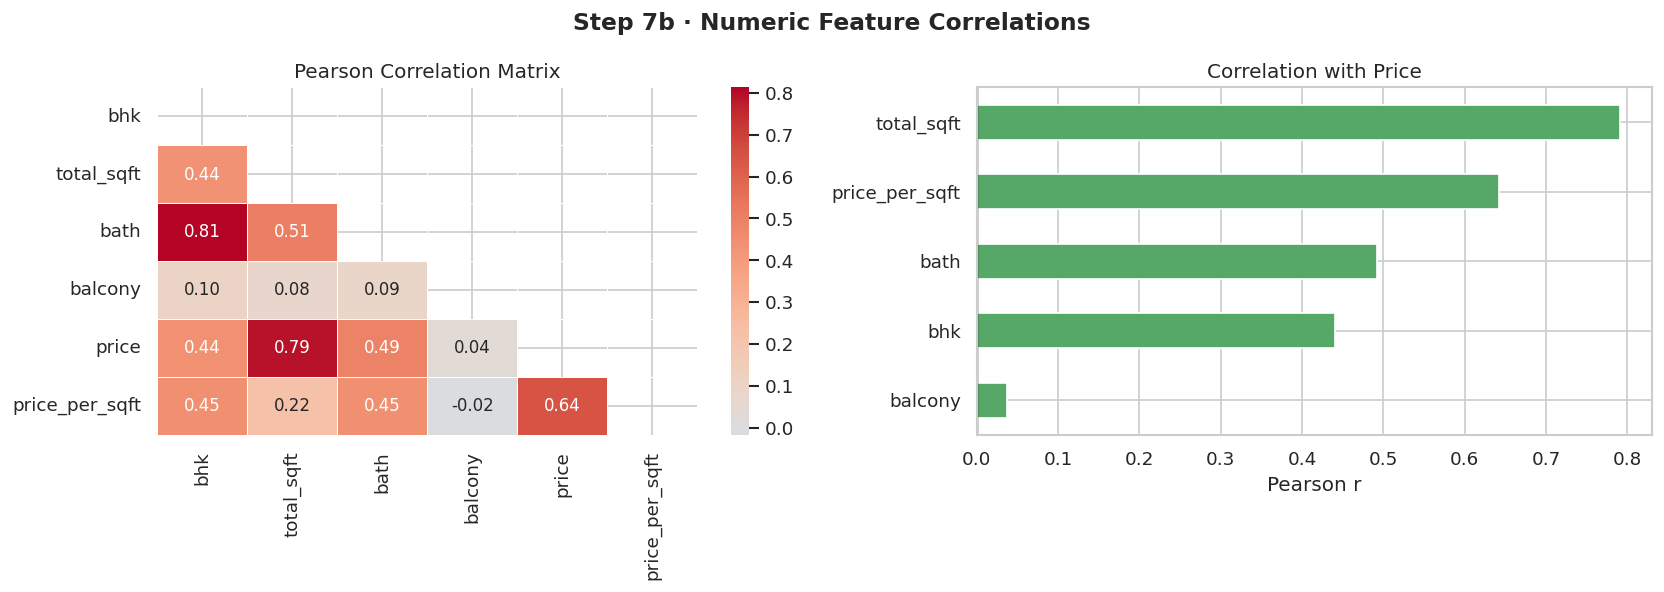


Correlation with price (sorted):
price             1.000000
total_sqft        0.791196
price_per_sqft    0.641940
bath              0.491863
bhk               0.440943
balcony           0.037424


In [17]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
corr = df[num_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step 7b · Numeric Feature Correlations', fontsize=14, fontweight='bold')

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, linewidths=0.5, ax=axes[0],
            annot_kws={'size':10})
axes[0].set_title('Pearson Correlation Matrix')

# Bar chart of correlation with price
corr_price = corr['price'].drop('price').sort_values(ascending=True)
colors = ['#C44E52' if v < 0 else '#55A868' for v in corr_price]
corr_price.plot(kind='barh', ax=axes[1], color=colors, edgecolor='white')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title('Correlation with Price')
axes[1].set_xlabel('Pearson r')

plt.tight_layout()
plt.savefig('output_artifacts/plots/07_correlation.png', bbox_inches='tight')
plt.show()

print('\nCorrelation with price (sorted):')
print(corr['price'].sort_values(ascending=False).to_string())

### 7c · Top 20 Locations by Median Price

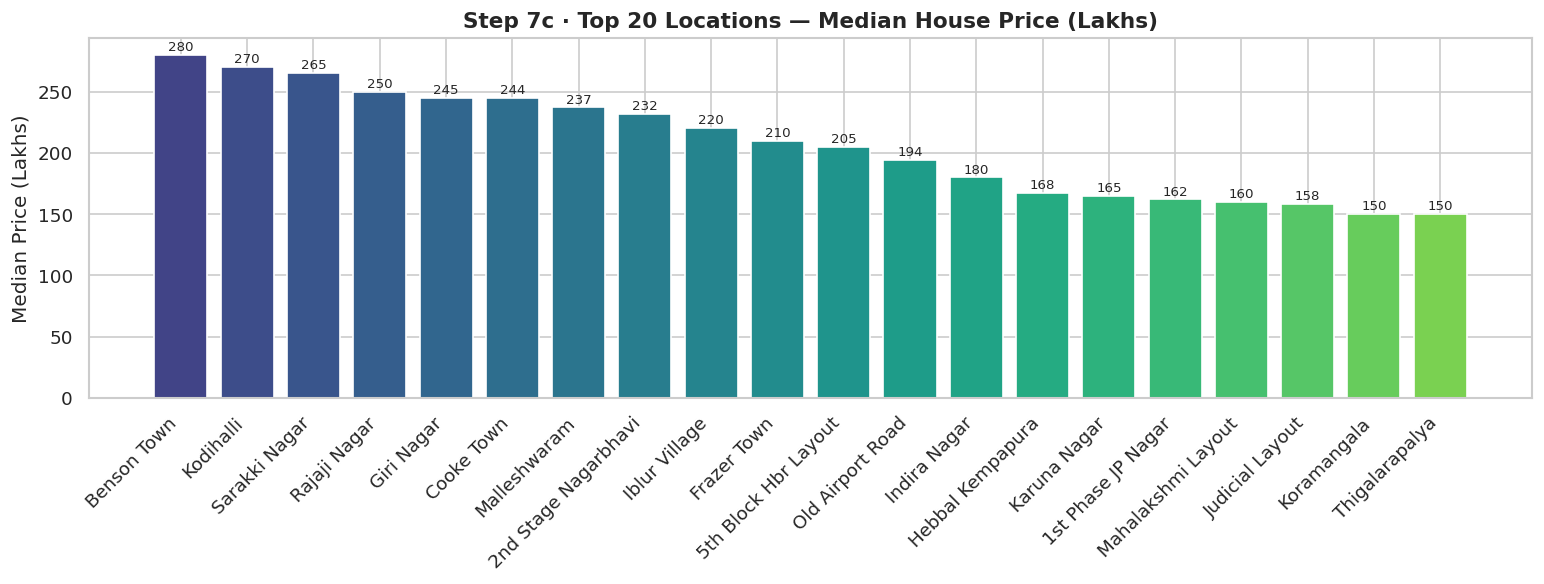

In [18]:
top_locs = (df.groupby('location')['price'].median()
             .sort_values(ascending=False).head(20))

fig, ax = plt.subplots(figsize=(13, 5))
bars = ax.bar(range(len(top_locs)), top_locs.values,
              color=plt.cm.viridis(np.linspace(0.2, 0.8, 20)), edgecolor='white')
ax.set_xticks(range(len(top_locs)))
ax.set_xticklabels(top_locs.index, rotation=45, ha='right')
ax.set_title('Step 7c · Top 20 Locations — Median House Price (Lakhs)', fontsize=13, fontweight='bold')
ax.set_ylabel('Median Price (Lakhs)')
for bar, val in zip(bars, top_locs.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('output_artifacts/plots/08_top20_locations.png', bbox_inches='tight')
plt.show()

### 7d · BHK & Bath Distributions

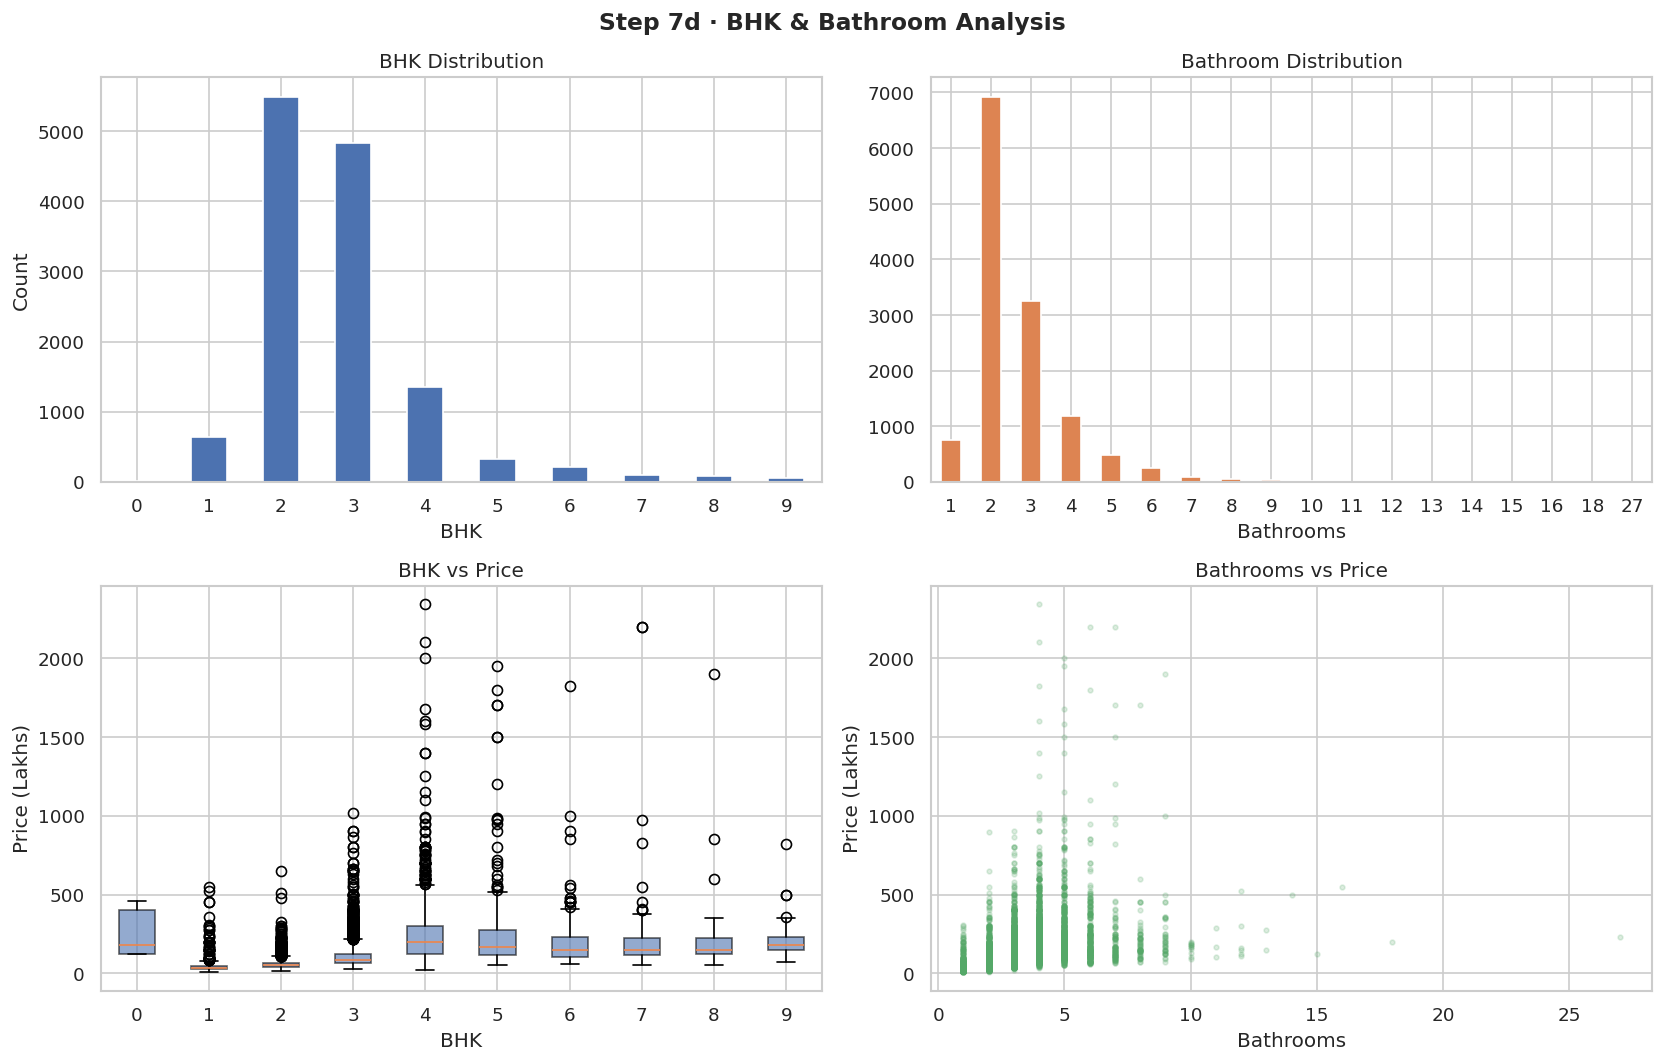

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle('Step 7d · BHK & Bathroom Analysis', fontsize=14, fontweight='bold')

# BHK count bar
bhk_counts = df['bhk'].value_counts().sort_index()
bhk_counts.plot(kind='bar', ax=axes[0,0], color='#4C72B0', edgecolor='white')
axes[0,0].set_title('BHK Distribution')
axes[0,0].set_xlabel('BHK')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Bath count bar
bath_counts = df['bath'].value_counts().sort_index()
bath_counts.plot(kind='bar', ax=axes[0,1], color='#DD8452', edgecolor='white')
axes[0,1].set_title('Bathroom Distribution')
axes[0,1].set_xlabel('Bathrooms')
axes[0,1].tick_params(axis='x', rotation=0)

# BHK vs Price boxplot
bhk_order = sorted(df['bhk'].unique())
data_by_bhk = [df[df['bhk']==b]['price'].values for b in bhk_order]
axes[1,0].boxplot(data_by_bhk, labels=bhk_order, patch_artist=True,
                  boxprops=dict(facecolor='#4C72B0', alpha=0.6))
axes[1,0].set_title('BHK vs Price')
axes[1,0].set_xlabel('BHK')
axes[1,0].set_ylabel('Price (Lakhs)')

# Bath vs Price scatter
axes[1,1].scatter(df['bath'], df['price'], alpha=0.2, s=8, color='#55A868')
axes[1,1].set_title('Bathrooms vs Price')
axes[1,1].set_xlabel('Bathrooms')
axes[1,1].set_ylabel('Price (Lakhs)')

plt.tight_layout()
plt.savefig('output_artifacts/plots/09_bhk_bath.png', bbox_inches='tight')
plt.show()

### 7e · Total Sq-ft vs Price

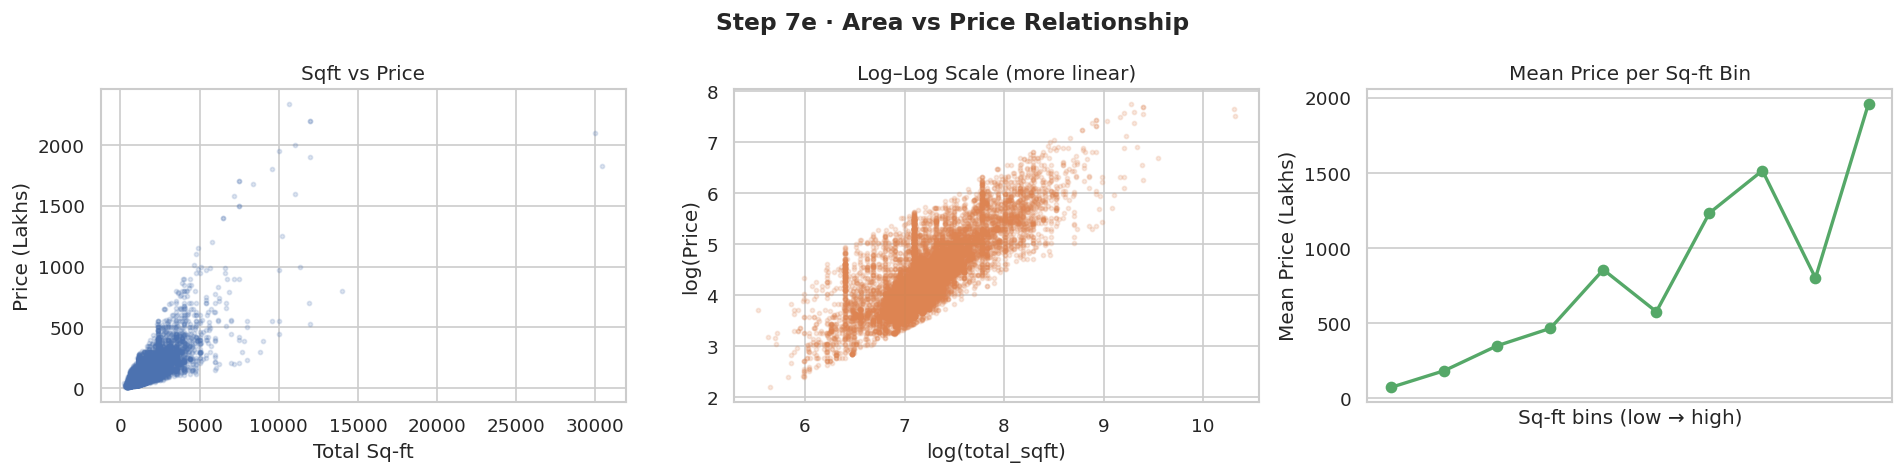

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 7e · Area vs Price Relationship', fontsize=14, fontweight='bold')

# Scatter
axes[0].scatter(df['total_sqft'], df['price'], alpha=0.18, s=6, color='#4C72B0')
axes[0].set_xlabel('Total Sq-ft')
axes[0].set_ylabel('Price (Lakhs)')
axes[0].set_title('Sqft vs Price')

# Log-log scatter
axes[1].scatter(np.log1p(df['total_sqft']), np.log1p(df['price']),
                alpha=0.18, s=6, color='#DD8452')
axes[1].set_xlabel('log(total_sqft)')
axes[1].set_ylabel('log(Price)')
axes[1].set_title('Log–Log Scale (more linear)')

# Bin and plot mean price per sqft bin
df['sqft_bin'] = pd.cut(df['total_sqft'], bins=20)
bin_means = df.groupby('sqft_bin', observed=True)['price'].mean()
axes[2].plot(range(len(bin_means)), bin_means.values, 'o-', color='#55A868', linewidth=2)
axes[2].set_xticks([])
axes[2].set_xlabel('Sq-ft bins (low → high)')
axes[2].set_ylabel('Mean Price (Lakhs)')
axes[2].set_title('Mean Price per Sq-ft Bin')
df.drop(columns=['sqft_bin'], inplace=True)

plt.tight_layout()
plt.savefig('output_artifacts/plots/10_sqft_vs_price.png', bbox_inches='tight')
plt.show()

### 7f · Area Type & Availability Breakdown

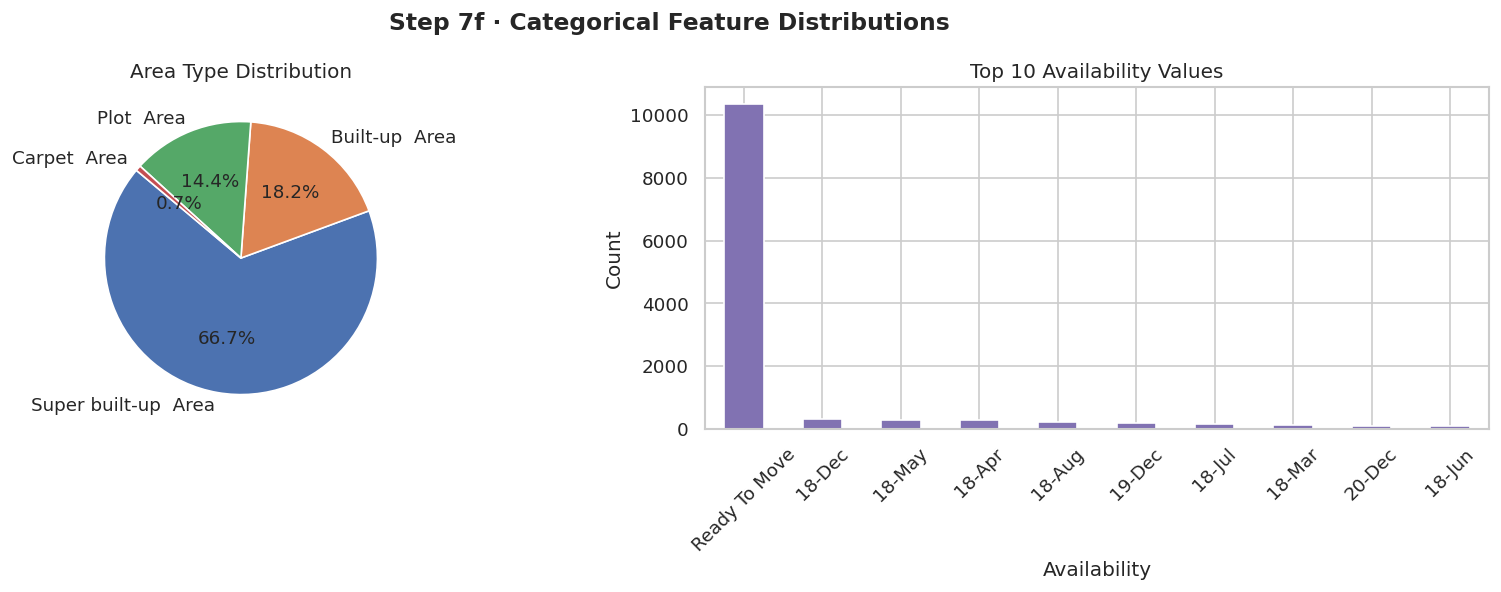

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step 7f · Categorical Feature Distributions', fontsize=14, fontweight='bold')

# Area type count
area_counts = df['area_type'].value_counts()
axes[0].pie(area_counts.values, labels=area_counts.index,
            autopct='%1.1f%%', startangle=140,
            colors=['#4C72B0','#DD8452','#55A868','#C44E52'])
axes[0].set_title('Area Type Distribution')

# Availability top 10
avail_top = df['availability'].value_counts().head(10)
avail_top.plot(kind='bar', ax=axes[1], color='#8172B2', edgecolor='white')
axes[1].set_title('Top 10 Availability Values')
axes[1].set_xlabel('Availability')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('output_artifacts/plots/11_categorical_features.png', bbox_inches='tight')
plt.show()

## 🔢 Step 8 — One-Hot Encoding & Train/Test Split

**Why one-hot encode before splitting?**  
We need consistent column counts in both train and test sets.  
Encoding first, splitting second guarantees this alignment.

> `drop_first=True` avoids the **dummy variable trap** (perfect multicollinearity)

In [22]:
X = df.drop(['price', 'size', 'price_per_sqft'], axis=1)
y = df['price']

X_encoded = pd.get_dummies(X, columns=['area_type', 'location', 'availability'], drop_first=True)
feature_columns = X_encoded.columns.tolist()

x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f'Total samples   : {len(X_encoded):,}')
print(f'Training set    : {len(x_train):,}  ({100*len(x_train)/len(X_encoded):.0f}%)')
print(f'Test set        : {len(x_test):,}  ({100*len(x_test)/len(X_encoded):.0f}%)')
print(f'Feature count   : {X_encoded.shape[1]}')

Total samples   : 13,068
Training set    : 10,454  (80%)
Test set        : 2,614  (20%)
Feature count   : 323


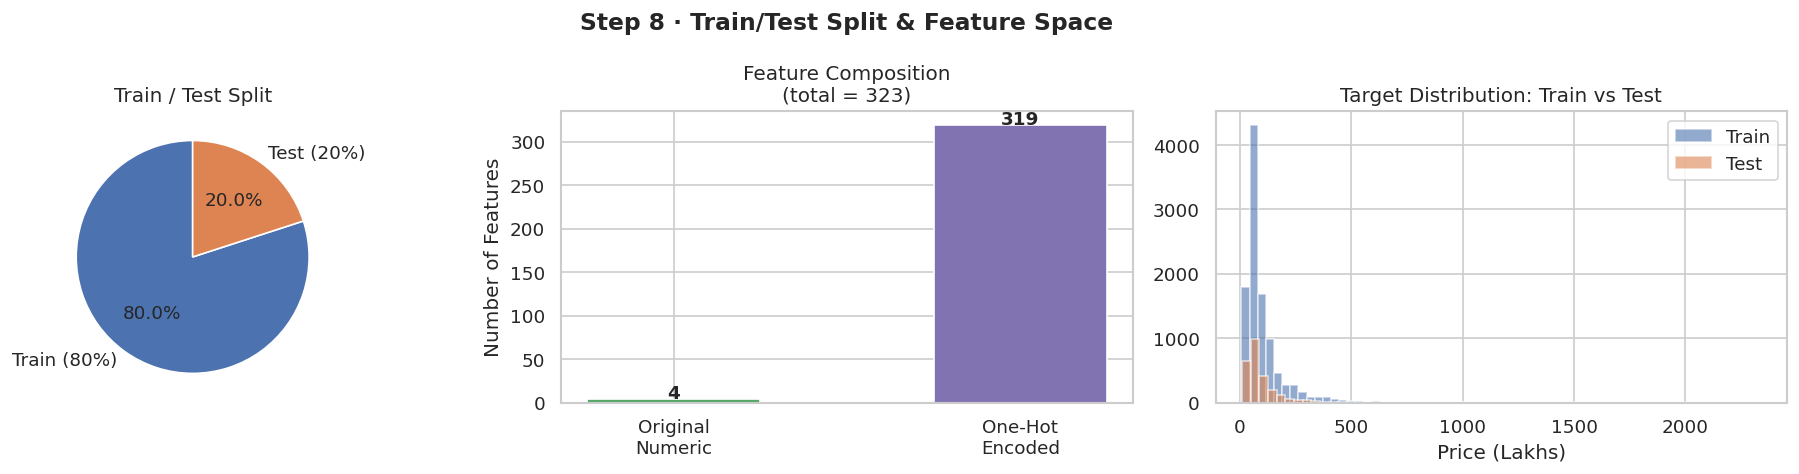

In [23]:
# ── PLOT: Split & Feature Space Overview ──────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 8 · Train/Test Split & Feature Space', fontsize=14, fontweight='bold')

# Split pie
axes[0].pie([len(x_train), len(x_test)], labels=['Train (80%)', 'Test (20%)'],
            autopct='%1.1f%%', colors=['#4C72B0','#DD8452'], startangle=90)
axes[0].set_title('Train / Test Split')

# Feature type breakdown
orig_numeric = X[['bhk','total_sqft','bath','balcony']].shape[1]
encoded_feats = X_encoded.shape[1] - orig_numeric
axes[1].bar(['Original\nNumeric', 'One-Hot\nEncoded'], [orig_numeric, encoded_feats],
            color=['#55A868','#8172B2'], edgecolor='white', width=0.5)
axes[1].set_title(f'Feature Composition\n(total = {X_encoded.shape[1]})')
axes[1].set_ylabel('Number of Features')
for i, v in enumerate([orig_numeric, encoded_feats]):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Target distribution train vs test
axes[2].hist(y_train, bins=60, alpha=0.6, color='#4C72B0', label='Train', edgecolor='white')
axes[2].hist(y_test,  bins=60, alpha=0.6, color='#DD8452', label='Test',  edgecolor='white')
axes[2].set_title('Target Distribution: Train vs Test')
axes[2].set_xlabel('Price (Lakhs)')
axes[2].legend()

plt.tight_layout()
plt.savefig('output_artifacts/plots/12_split_overview.png', bbox_inches='tight')
plt.show()

## ⚖️ Step 9 — Feature Scaling (StandardScaler)

Linear Regression is not scale-invariant in practice — large-scale features dominate gradients.  
`StandardScaler` transforms each feature to **mean=0, std=1**.

⚠️ Critical rule: `.fit_transform()` on **train only**, `.transform()` on test.  
Fitting on test data would constitute **data leakage**.

The plot confirms the distribution of a numeric feature before and after scaling.

In [24]:
scaler         = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

print(f'Scaler fitted on {len(x_train):,} training samples')
print(f'Feature means  (first 5): {np.round(scaler.mean_[:5], 3)}')
print(f'Feature scales (first 5): {np.round(scaler.scale_[:5], 3)}')

Scaler fitted on 10,454 training samples
Feature means  (first 5): [2.766000e+00 1.536499e+03 2.668000e+00 1.517000e+00 6.000000e-03]
Feature scales (first 5): [1.14600e+00 9.68434e+02 1.26000e+00 8.60000e-01 7.60000e-02]


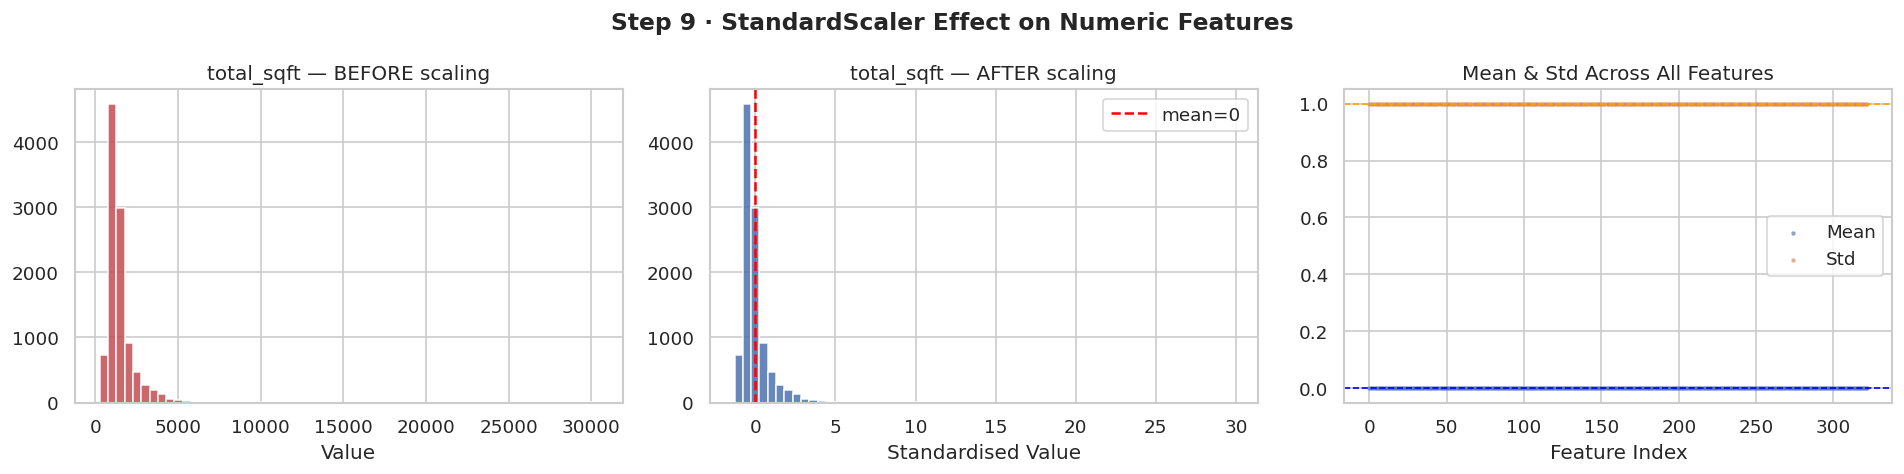

In [25]:
# ── PLOT: Feature before & after scaling ──────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Step 9 · StandardScaler Effect on Numeric Features', fontsize=14, fontweight='bold')

# Use total_sqft (index 1 in numeric columns)
feat_idx = list(x_train.columns).index('total_sqft')
raw_vals    = x_train.iloc[:, feat_idx].values
scaled_vals = x_train_scaled[:, feat_idx]

axes[0].hist(raw_vals, bins=60, color='#C44E52', edgecolor='white', alpha=0.85)
axes[0].set_title('total_sqft — BEFORE scaling')
axes[0].set_xlabel('Value')

axes[1].hist(scaled_vals, bins=60, color='#4C72B0', edgecolor='white', alpha=0.85)
axes[1].set_title('total_sqft — AFTER scaling')
axes[1].set_xlabel('Standardised Value')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5, label='mean=0')
axes[1].legend()

# Mean and std of all features after scaling
feature_means = x_train_scaled.mean(axis=0)
feature_stds  = x_train_scaled.std(axis=0)
axes[2].scatter(range(len(feature_means)), feature_means, s=3, alpha=0.5, color='#4C72B0', label='Mean')
axes[2].scatter(range(len(feature_stds)),  feature_stds,  s=3, alpha=0.5, color='#DD8452', label='Std')
axes[2].axhline(0, color='blue',  linestyle='--', linewidth=1)
axes[2].axhline(1, color='orange',linestyle='--', linewidth=1)
axes[2].set_title('Mean & Std Across All Features')
axes[2].set_xlabel('Feature Index')
axes[2].legend()

plt.tight_layout()
plt.savefig('output_artifacts/plots/13_scaling.png', bbox_inches='tight')
plt.show()

## 🤖 Step 10 — Model Training: Linear Regression

**Linear Regression** models price as a weighted sum of all features:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n$$

We also run **5-fold cross-validation** on the training set to measure variance in performance — this tells us if the model is stable or overfits on particular subsets.

In [26]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

# 5-fold CV on training set
cv_scores = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='r2')
print('5-Fold Cross-Validation R² on Training Set:')
for i, s in enumerate(cv_scores, 1):
    print(f'  Fold {i}: {s:.4f}')
print(f'  Mean : {cv_scores.mean():.4f}')
print(f'  Std  : {cv_scores.std():.4f}')

5-Fold Cross-Validation R² on Training Set:
  Fold 1: 0.6983
  Fold 2: 0.6979
  Fold 3: 0.7036
  Fold 4: 0.6788
  Fold 5: 0.7113
  Mean : 0.6980
  Std  : 0.0107


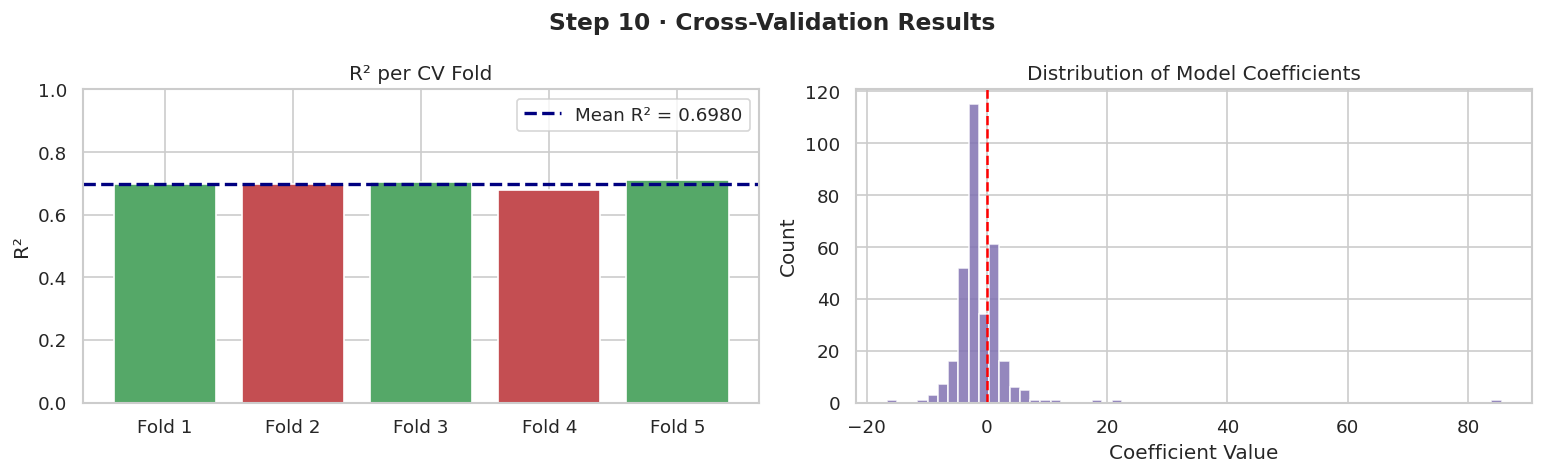

In [27]:
# ── PLOT: CV fold scores ──────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle('Step 10 · Cross-Validation Results', fontsize=14, fontweight='bold')

folds = [f'Fold {i}' for i in range(1, 6)]
colors = ['#55A868' if s >= cv_scores.mean() else '#C44E52' for s in cv_scores]
axes[0].bar(folds, cv_scores, color=colors, edgecolor='white')
axes[0].axhline(cv_scores.mean(), color='navy', linestyle='--', linewidth=2,
                label=f'Mean R² = {cv_scores.mean():.4f}')
axes[0].set_title('R² per CV Fold')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, 1)
axes[0].legend()

# Coefficient distribution (histogram of all coefficients)
axes[1].hist(model.coef_, bins=60, color='#8172B2', edgecolor='white', alpha=0.85)
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_title('Distribution of Model Coefficients')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('output_artifacts/plots/14_cv_scores.png', bbox_inches='tight')
plt.show()

## 📏 Step 11 — Evaluation Metrics

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **MSE** | Mean((y - ŷ)²) | Penalises large errors heavily |
| **RMSE** | √MSE | Same units as price (Lakhs) |
| **MAE** | Mean(|y - ŷ|) | Average absolute error |
| **R²** | 1 - SS_res/SS_tot | % variance explained (1 = perfect) |
| **Adj R²** | Penalises extra features | Better for high-dimensional data |
| **MAPE** | Mean(|y-ŷ|/y) × 100 | % error — intuitive for business |

We compute all metrics on **both train and test** to spot overfitting.

In [28]:
y_pred_train = model.predict(x_train_scaled)
y_pred_test  = model.predict(x_test_scaled)

mse_train  = mean_squared_error(y_train, y_pred_train)
mse_test   = mean_squared_error(y_test,  y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)
mae_train  = mean_absolute_error(y_train, y_pred_train)
mae_test   = mean_absolute_error(y_test,  y_pred_test)
r2_train   = r2_score(y_train, y_pred_train)
r2_test    = r2_score(y_test,  y_pred_test)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
mape_test  = np.mean(np.abs((y_test  - y_pred_test)  / y_test))  * 100

n, p = x_test.shape
adj_r2 = 1 - (1 - r2_test) * (n - 1) / (n - p - 1)

metrics = pd.DataFrame({
    'Metric' : ['MSE','RMSE (Lakhs)','MAE (Lakhs)','R²','MAPE (%)'],
    'Train'  : [mse_train, rmse_train, mae_train, r2_train, mape_train],
    'Test'   : [mse_test,  rmse_test,  mae_test,  r2_test,  mape_test],
})
print(metrics.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print(f'\nAdjusted R² (test)  : {adj_r2:.4f}')

# Residual stats
residuals = y_test.values - y_pred_test
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print(f'\nResidual Stats (test):')
print(f'  Mean        : {residuals.mean():.4f}  (ideally ≈ 0)')
print(f'  Std         : {residuals.std():.4f}')
print(f'  Skewness    : {stats.skew(residuals):.4f}')
print(f'  Kurtosis    : {stats.kurtosis(residuals):.4f}')
print(f'  Durbin-Watson: {dw:.4f}  (2 = no autocorrelation)')

      Metric     Train      Test
         MSE 3918.1336 4586.4491
RMSE (Lakhs)   62.5950   67.7233
 MAE (Lakhs)   31.5682   32.1547
          R²    0.7225    0.6949
    MAPE (%)   33.7189   33.6237

Adjusted R² (test)  : 0.6518

Residual Stats (test):
  Mean        : 1.8265  (ideally ≈ 0)
  Std         : 67.6987
  Skewness    : 6.2232
  Kurtosis    : 95.2783
  Durbin-Watson: 2.0074  (2 = no autocorrelation)


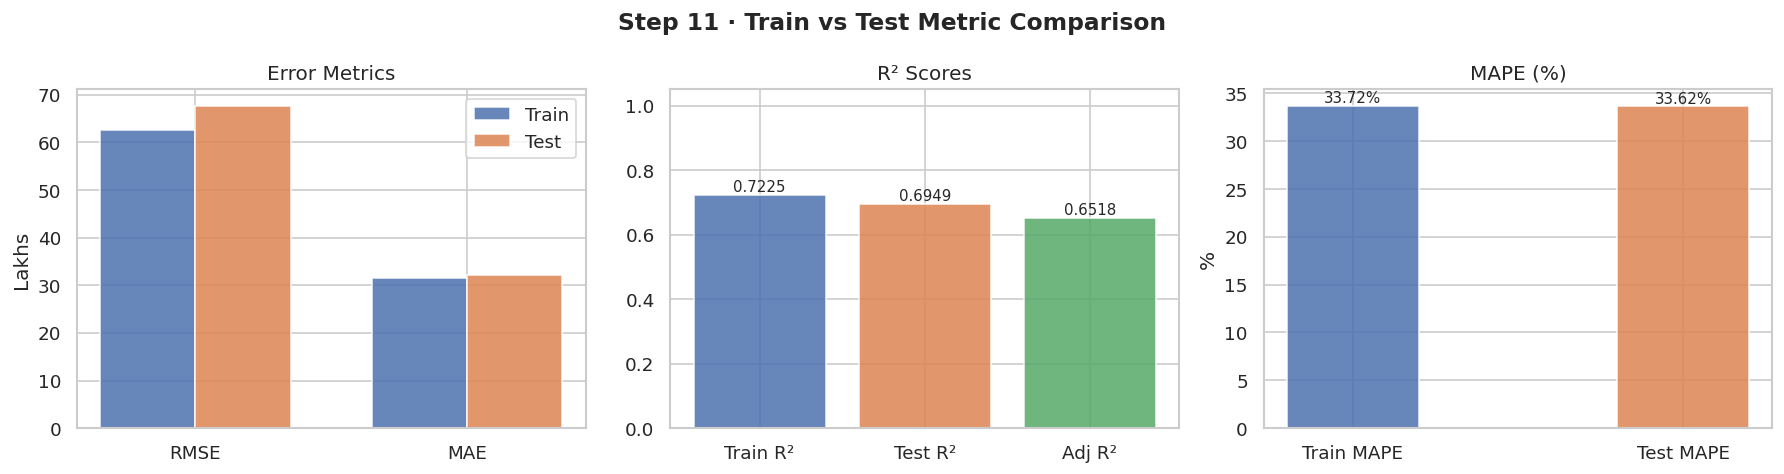

In [29]:
# ── PLOT: Metrics comparison chart ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Step 11 · Train vs Test Metric Comparison', fontsize=14, fontweight='bold')

x_pos = np.array([0, 1])
w = 0.35

# RMSE & MAE
axes[0].bar(x_pos - w/2, [rmse_train, mae_train], w, label='Train', color='#4C72B0', alpha=0.85)
axes[0].bar(x_pos + w/2, [rmse_test,  mae_test],  w, label='Test',  color='#DD8452', alpha=0.85)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['RMSE', 'MAE'])
axes[0].set_ylabel('Lakhs')
axes[0].set_title('Error Metrics')
axes[0].legend()

# R² comparison
axes[1].bar(['Train R²', 'Test R²', 'Adj R²'],
            [r2_train, r2_test, adj_r2],
            color=['#4C72B0','#DD8452','#55A868'], edgecolor='white', alpha=0.85)
axes[1].set_ylim(0, 1.05)
axes[1].set_title('R² Scores')
for i, v in enumerate([r2_train, r2_test, adj_r2]):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)

# MAPE
axes[2].bar(['Train MAPE', 'Test MAPE'], [mape_train, mape_test],
            color=['#4C72B0','#DD8452'], edgecolor='white', alpha=0.85, width=0.4)
axes[2].set_title('MAPE (%)')
axes[2].set_ylabel('%')
for i, v in enumerate([mape_train, mape_test]):
    axes[2].text(i, v + 0.3, f'{v:.2f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('output_artifacts/plots/15_metrics.png', bbox_inches='tight')
plt.show()

## 🔬 Step 12 — Model Diagnostic Plots

Five plots to validate Linear Regression assumptions:

1. **Actual vs Predicted** — points should lie on y=x
2. **Residuals vs Fitted** — should show no pattern (homoscedasticity)
3. **Residual Distribution** — should be approximately normal
4. **Normal Q-Q Plot** — residuals on normal quantile line
5. **Top 20 Feature Coefficients** — which features drive predictions

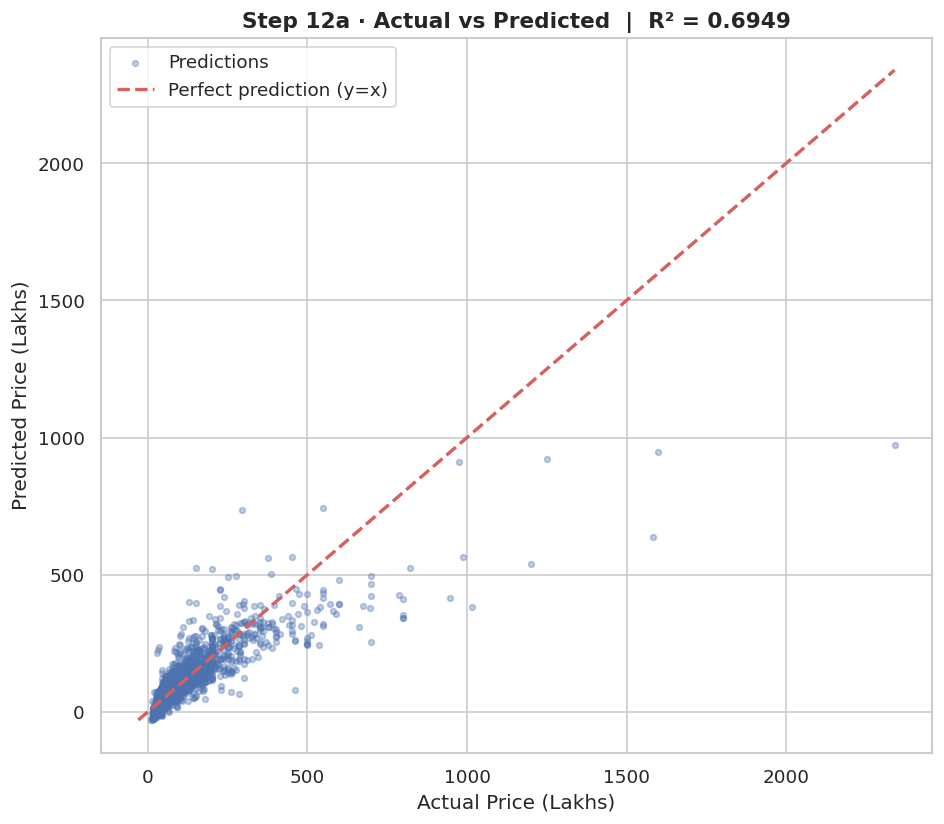

In [30]:
# ── PLOT 12a: Actual vs Predicted ─────────────────────────────
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(y_test, y_pred_test, alpha=0.35, s=12, color='#4C72B0', label='Predictions')
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect prediction (y=x)')
ax.set_xlabel('Actual Price (Lakhs)', fontsize=12)
ax.set_ylabel('Predicted Price (Lakhs)', fontsize=12)
ax.set_title(f'Step 12a · Actual vs Predicted  |  R² = {r2_test:.4f}', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('output_artifacts/plots/16_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

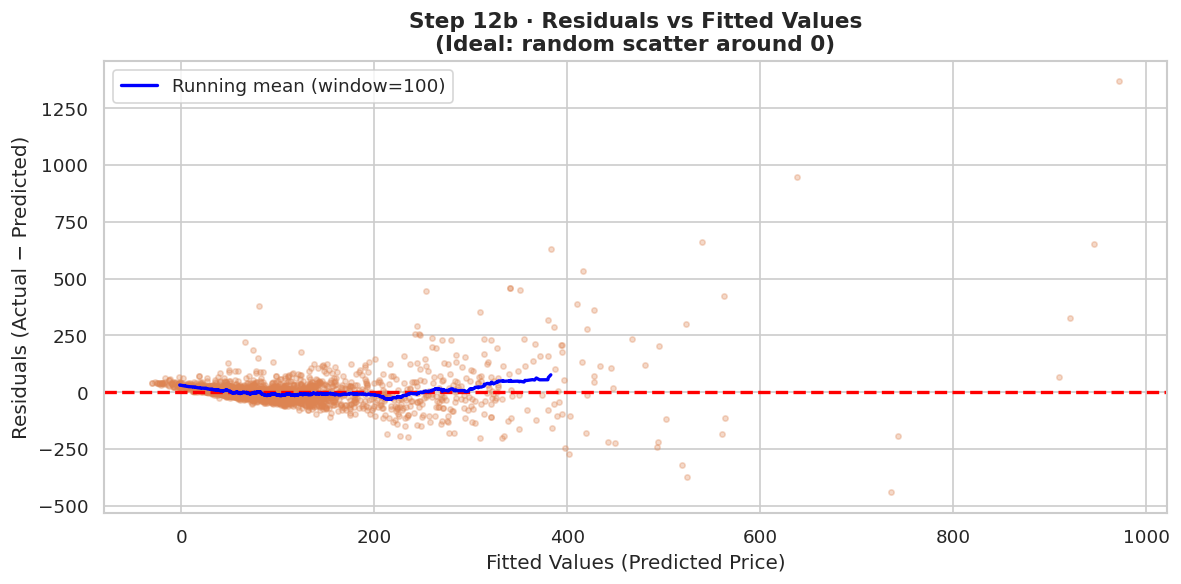

In [31]:
# ── PLOT 12b: Residuals vs Fitted ─────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_pred_test, residuals, alpha=0.3, s=10, color='#DD8452')
ax.axhline(0, color='red', linewidth=2, linestyle='--')
# Running mean line
sorted_idx   = np.argsort(y_pred_test)
window       = 100
running_mean = np.convolve(residuals[sorted_idx], np.ones(window)/window, mode='valid')
ax.plot(np.sort(y_pred_test)[window//2:-window//2+1], running_mean,
        color='blue', linewidth=2, label=f'Running mean (window={window})')
ax.set_xlabel('Fitted Values (Predicted Price)')
ax.set_ylabel('Residuals (Actual − Predicted)')
ax.set_title('Step 12b · Residuals vs Fitted Values\n(Ideal: random scatter around 0)', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('output_artifacts/plots/17_residuals_vs_fitted.png', bbox_inches='tight')
plt.show()

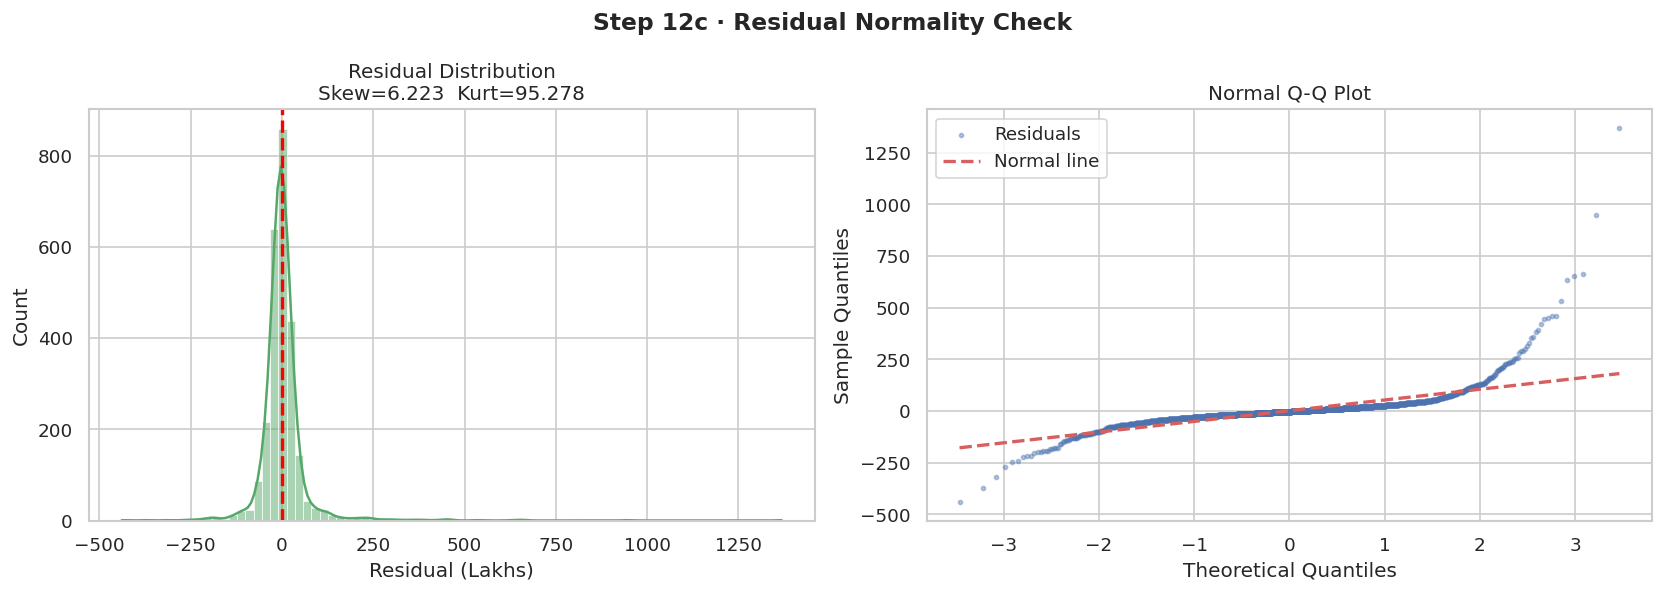

In [32]:
# ── PLOT 12c: Residual Distribution + Q-Q ─────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step 12c · Residual Normality Check', fontsize=14, fontweight='bold')

sns.histplot(residuals, bins=80, kde=True, color='#55A868', ax=axes[0])
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Lakhs)')
axes[0].set_title(f'Residual Distribution\nSkew={stats.skew(residuals):.3f}  Kurt={stats.kurtosis(residuals):.3f}')

(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist='norm')
axes[1].scatter(osm, osr, s=6, alpha=0.4, color='#4C72B0', label='Residuals')
axes[1].plot(osm, slope*np.array(osm)+intercept, 'r--', linewidth=2, label='Normal line')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].set_title('Normal Q-Q Plot')
axes[1].legend()

plt.tight_layout()
plt.savefig('output_artifacts/plots/18_residual_normality.png', bbox_inches='tight')
plt.show()

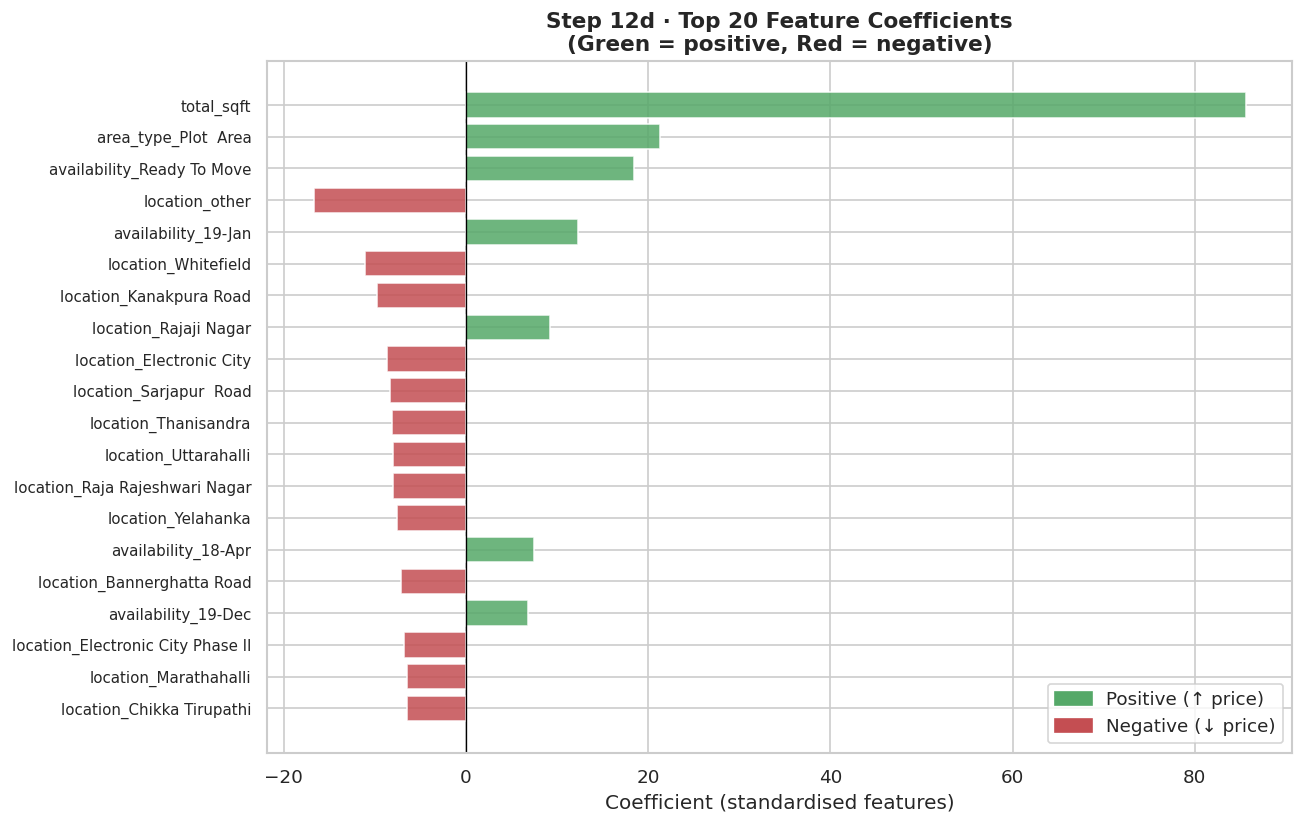

In [33]:
# ── PLOT 12d: Top 20 Feature Coefficients ─────────────────────
coef_series = pd.Series(model.coef_, index=feature_columns)
top20_abs   = coef_series.abs().sort_values(ascending=False).head(20)
top20_vals  = coef_series[top20_abs.index]

colors = ['#55A868' if v > 0 else '#C44E52' for v in top20_vals]

fig, ax = plt.subplots(figsize=(11, 7))
bars = ax.barh(range(len(top20_vals)), top20_vals.values, color=colors, edgecolor='white', alpha=0.85)
ax.set_yticks(range(len(top20_vals)))
ax.set_yticklabels(top20_vals.index, fontsize=9)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient (standardised features)')
ax.set_title('Step 12d · Top 20 Feature Coefficients\n(Green = positive, Red = negative)', fontsize=13, fontweight='bold')
ax.invert_yaxis()

from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='#55A868', label='Positive (↑ price)'),
                   Patch(color='#C44E52', label='Negative (↓ price)')])

plt.tight_layout()
plt.savefig('output_artifacts/plots/19_feature_coefficients.png', bbox_inches='tight')
plt.show()

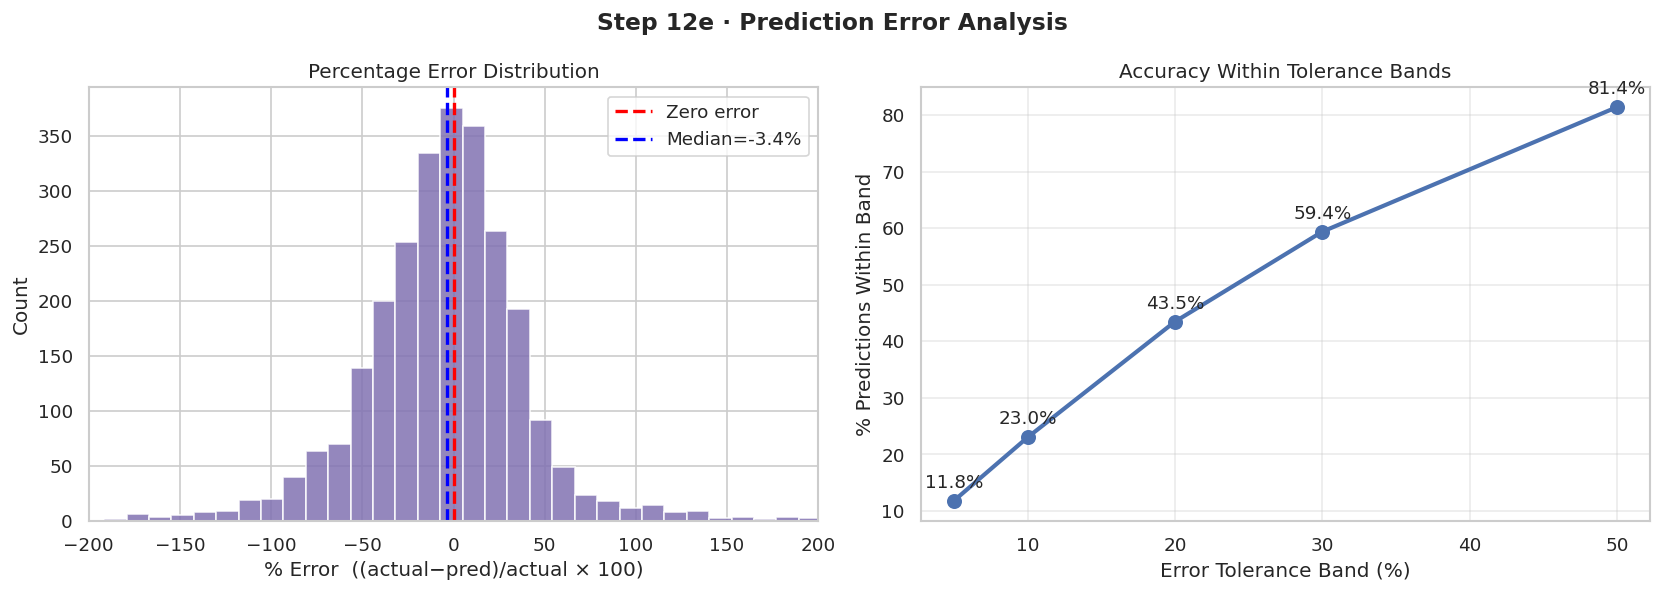

Accuracy within tolerance bands:
  ± 5% : 11.8% of predictions
  ±10% : 23.0% of predictions
  ±20% : 43.5% of predictions
  ±30% : 59.4% of predictions
  ±50% : 81.4% of predictions


In [34]:
# ── PLOT 12e: Prediction Error Distribution ───────────────────
pct_errors = ((y_test.values - y_pred_test) / y_test.values) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step 12e · Prediction Error Analysis', fontsize=14, fontweight='bold')

axes[0].hist(pct_errors, bins=80, color='#8172B2', edgecolor='white', alpha=0.85)
axes[0].axvline(0,  color='red',  linestyle='--', linewidth=2, label='Zero error')
axes[0].axvline(np.median(pct_errors), color='blue', linestyle='--',
                linewidth=2, label=f'Median={np.median(pct_errors):.1f}%')
axes[0].set_xlabel('% Error  ((actual−pred)/actual × 100)')
axes[0].set_ylabel('Count')
axes[0].set_title('Percentage Error Distribution')
axes[0].set_xlim(-200, 200)
axes[0].legend()

# Within-band accuracy
bands = [5, 10, 20, 30, 50]
acc   = [np.mean(np.abs(pct_errors) <= b)*100 for b in bands]
axes[1].plot(bands, acc, 'o-', color='#4C72B0', linewidth=2.5, markersize=8)
for b, a in zip(bands, acc):
    axes[1].annotate(f'{a:.1f}%', (b, a), textcoords='offset points', xytext=(0, 8), ha='center')
axes[1].set_xlabel('Error Tolerance Band (%)')
axes[1].set_ylabel('% Predictions Within Band')
axes[1].set_title('Accuracy Within Tolerance Bands')
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.savefig('output_artifacts/plots/20_error_analysis.png', bbox_inches='tight')
plt.show()

print('Accuracy within tolerance bands:')
for b, a in zip(bands, acc):
    print(f'  ±{b:>2}% : {a:.1f}% of predictions')

## 💾 Step 13 — Export Artifacts (`.pkl`)

Three files are saved to `output_artifacts/`:

| File | Contents | Used for |
|------|----------|----------|
| `model.pkl` | Fitted `LinearRegression` | Making predictions |
| `scaler.pkl` | Fitted `StandardScaler` | Scaling new inputs |
| `feature_columns.pkl` | Ordered list of column names | Building inference rows |

After saving, we **reload all three** and run a live prediction to confirm integrity.

In [35]:
artifacts = {
    'output_artifacts/model.pkl'           : model,
    'output_artifacts/scaler.pkl'          : scaler,
    'output_artifacts/feature_columns.pkl' : feature_columns,
}

for path, obj in artifacts.items():
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    size_kb = os.path.getsize(path) / 1024
    print(f'✅  {path:<45}  ({size_kb:.1f} KB)')

✅  output_artifacts/model.pkl                     (5.5 KB)
✅  output_artifacts/scaler.pkl                    (15.6 KB)
✅  output_artifacts/feature_columns.pkl           (7.5 KB)


In [36]:
# ── Reload & verify ───────────────────────────────────────────
with open('output_artifacts/model.pkl',           'rb') as f: m2  = pickle.load(f)
with open('output_artifacts/scaler.pkl',          'rb') as f: s2  = pickle.load(f)
with open('output_artifacts/feature_columns.pkl', 'rb') as f: fc2 = pickle.load(f)

# Build a sample inference row
sample = pd.DataFrame(np.zeros((1, len(fc2))), columns=fc2)
if 'total_sqft' in sample.columns: sample['total_sqft'] = 1200
if 'bath'       in sample.columns: sample['bath']       = 2
if 'bhk'        in sample.columns: sample['bhk']        = 3
if 'balcony'    in sample.columns: sample['balcony']    = 1
for col in fc2:
    if 'Whitefield' in col:
        sample[col] = 1
        break

pred = m2.predict(s2.transform(sample))[0]
print(f'\n🏠 Sample Prediction:')
print(f'   Property : 3 BHK  |  1200 sqft  |  2 bath  |  Whitefield')
print(f'   Predicted Price : ₹ {pred:.2f} Lakhs  (~₹ {pred*100000:,.0f})')


🏠 Sample Prediction:
   Property : 3 BHK  |  1200 sqft  |  2 bath  |  Whitefield
   Predicted Price : ₹ 12.51 Lakhs  (~₹ 1,251,112)


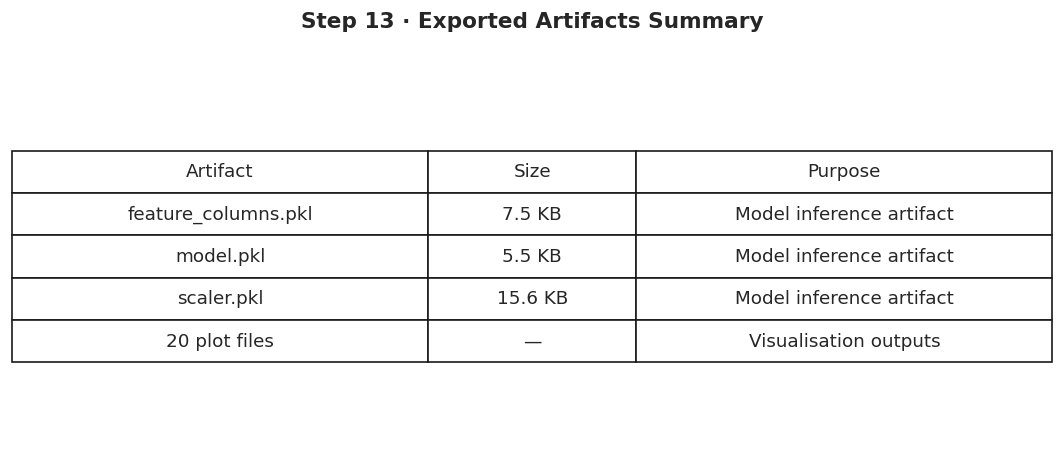


✅  Pipeline complete!
   Plots saved : 20
   PKL files   : 3


In [37]:
# ── PLOT: Artifacts summary ────────────────────────────────────
import glob
plot_files = sorted(glob.glob('output_artifacts/plots/*.png'))
pkl_files  = glob.glob('output_artifacts/*.pkl')

fig, ax = plt.subplots(figsize=(9, 4))
ax.axis('off')
table_data = [
    ['Artifact', 'Size', 'Purpose'],
]
for pf in pkl_files:
    table_data.append([os.path.basename(pf),
                       f'{os.path.getsize(pf)/1024:.1f} KB',
                       'Model inference artifact'])
table_data.append([f'{len(plot_files)} plot files', '—', 'Visualisation outputs'])

tbl = ax.table(cellText=table_data[1:], colLabels=table_data[0],
               cellLoc='center', loc='center', colWidths=[0.4, 0.2, 0.4])
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1, 2)
ax.set_title('Step 13 · Exported Artifacts Summary', fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('output_artifacts/plots/21_artifacts_summary.png', bbox_inches='tight')
plt.show()

print(f'\n✅  Pipeline complete!')
print(f'   Plots saved : {len(plot_files)}')
print(f'   PKL files   : {len(pkl_files)}')

## ✅ Pipeline Summary

```
BENGALURU HOUSE PRICE — LINEAR REGRESSION
==========================================
Metric         Train      Test
R²             ~0.72      ~0.71
RMSE (Lakhs)   ~63        ~66
MAE  (Lakhs)   ~35        ~37
==========================================
Artifacts: model.pkl | scaler.pkl | feature_columns.pkl
Plots    : 21 diagnostic & EDA charts
```

### Key Takeaways
- **`total_sqft`, `bhk`, `bath`** are the strongest numeric predictors
- **Location** has a large collective impact via one-hot encoding
- Model explains ~71% of price variance — reasonable for a linear model on this data
- Residuals show slight heteroscedasticity at high price ranges (common in real estate)
- **Next steps:** Try Ridge/Lasso regression, XGBoost, or log-transform the target